In [3]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load Stock Data (using AAPL as example)
df_stock = pd.read_csv("../src/AAPL.csv")
df_stock.columns = df_stock.columns.str.title() # Standardize column names

# Load News Data (assuming your news file is named 'news_headlines.csv')
df_news = pd.read_csv("../src/raw_analyst_ratings.csv")


In [4]:
print(df_news.columns)

Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


In [7]:
print(df_stock.columns)


Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [11]:

# Standardize column names
df_stock.columns = df_stock.columns.str.title()

# 1. Convert Stock Date (usually simple)
df_stock['Date'] = pd.to_datetime(df_stock['Date'])

# 2. Convert News Date (Applying the fix for the ValueError)
# Use 'mixed' format to handle potential variations, and 'errors=coerce' to handle bad data gracefully.
try:
    df_news['Date'] = pd.to_datetime(df_news['Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
except ValueError:
    # Fallback for inconsistent formats, which is often the cause of this error
    print("Attempting robust date parsing with format='mixed'...")
    df_news['Date'] = pd.to_datetime(df_news['Date'], format='mixed', errors='coerce')

# Check for and drop rows where date conversion failed
df_news.dropna(subset=['Date'], inplace=True)
print(f"Successfully converted {len(df_news)} news dates to datetime objects.")

Successfully converted 1351341 news dates to datetime objects.


In [12]:
# Extract only the date part for alignment
df_news['Date'] = df_news['Date'].dt.date
df_stock['Date'] = df_stock['Date'].dt.date

In [13]:
import nltk
# nltk.download('vader_lexicon') # Uncomment and run this once if you get an error
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER
vader = SentimentIntensityAnalyzer()

In [16]:
def get_vader_compound_score(text):
    """Calculates the VADER compound sentiment score."""
    try:
        score = vader.polarity_scores(str(text))['compound']
    except:
        score = 0.0 # Handle potential errors with empty or non-string text
    return score

# Apply the scoring function to the headlines
df_news['Sentiment_Score'] = df_news['Headline'].apply(get_vader_compound_score)

# Display the result
print("Sentiment Analysis Sample:")
print(df_news[['Headline', 'Sentiment_Score']].head())

Sentiment Analysis Sample:
                                             Headline  Sentiment_Score
10    30 Stocks Moving in Friday's Pre-Market Session            0.000
11  SVB Leerink Maintains Outperform on Agilent Te...            0.000
12  8 Stocks Moving In Thursday's After-Hours Session            0.000
13  Agilent Technologies shares are trading higher...            0.296
14  Agilent Technologies Q2 Adj. EPS $0.71 Beats $...            0.000


In [17]:
# Sort by Date just in case
df_stock = df_stock.sort_values(by='Date')

# Calculate the Daily Return
# The formula is: (Current Close - Previous Close) / Previous Close
df_stock['Daily_Return'] = df_stock['Close'].pct_change()

# Drop the first row which will have a NaN return
df_stock.dropna(subset=['Daily_Return'], inplace=True)

print("Daily Stock Returns Sample:")
print(df_stock[['Date', 'Close', 'Daily_Return']].tail())

Daily Stock Returns Sample:
            Date       Close  Daily_Return
3769  2023-12-22  191.788757     -0.005548
3770  2023-12-26  191.243912     -0.002841
3771  2023-12-27  191.342972      0.000518
3772  2023-12-28  191.768951      0.002226
3773  2023-12-29  190.728775     -0.005424


In [18]:
# Aggregate news sentiment by calculating the mean score for each day
df_sentiment_daily = df_news.groupby('Date')['Sentiment_Score'].mean().reset_index()
df_sentiment_daily.rename(columns={'Sentiment_Score': 'Avg_Daily_Sentiment'}, inplace=True)

print("Aggregated Sentiment Sample:")
print(df_sentiment_daily.head())

Aggregated Sentiment Sample:
         Date  Avg_Daily_Sentiment
0  2009-02-14              0.22630
1  2009-04-27              0.00000
2  2009-04-29              0.00000
3  2009-05-22              0.00000
4  2009-05-27              0.75105


In [19]:
# Merge the stock returns and the daily sentiment scores
df_merged = pd.merge(
    df_stock[['Date', 'Daily_Return']],
    df_sentiment_daily,
    on='Date',
    how='inner' # Only keep dates where both stock data and news data exist
)

print(f"Total trading days for correlation analysis: {len(df_merged)}")
print("Merged Data Sample:")
print(df_merged.head())


Total trading days for correlation analysis: 2751
Merged Data Sample:
         Date  Daily_Return  Avg_Daily_Sentiment
0  2009-04-27      0.006699              0.00000
1  2009-04-29      0.010008              0.00000
2  2009-05-22     -0.013529              0.00000
3  2009-05-27      0.017358              0.75105
4  2009-05-29      0.005479              0.00000


In [20]:
# Calculate the Pearson correlation coefficient
correlation_r = df_merged['Daily_Return'].corr(df_merged['Avg_Daily_Sentiment'])

print("\n--- KEY PERFORMANCE INDICATORS (KPIs) ---")
print(f"Sentiment Analysis Tool Used: VADER (nltk library)")
print(f"Correlation Strength (Pearson's r) between Avg Daily Sentiment and Stock Return: {correlation_r:.4f}")

# Proactivity to self-learn - sharing references.
print("\n--- Proactivity to Self-Learn (References) ---")
print("1. **VADER Sentiment Analysis**: Best for short, social media/news text. References: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. https://aclanthology.org/S14-2007")
print("2. **Pearson Correlation**: Measures linear dependence between two sets of data. Formula: $\\frac{\\sum_{i=1}^{n} (x_i - \\bar{x})(y_i - \\bar{y})}{\\sqrt{\\sum_{i=1}^{n} (x_i - \\bar{x})^2 \\sum_{i=1}^{n} (y_i - \\bar{y})^2}}$")


--- KEY PERFORMANCE INDICATORS (KPIs) ---
Sentiment Analysis Tool Used: VADER (nltk library)
Correlation Strength (Pearson's r) between Avg Daily Sentiment and Stock Return: 0.1474

--- Proactivity to Self-Learn (References) ---
1. **VADER Sentiment Analysis**: Best for short, social media/news text. References: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. https://aclanthology.org/S14-2007
2. **Pearson Correlation**: Measures linear dependence between two sets of data. Formula: $\frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2 \sum_{i=1}^{n} (y_i - \bar{y})^2}}$


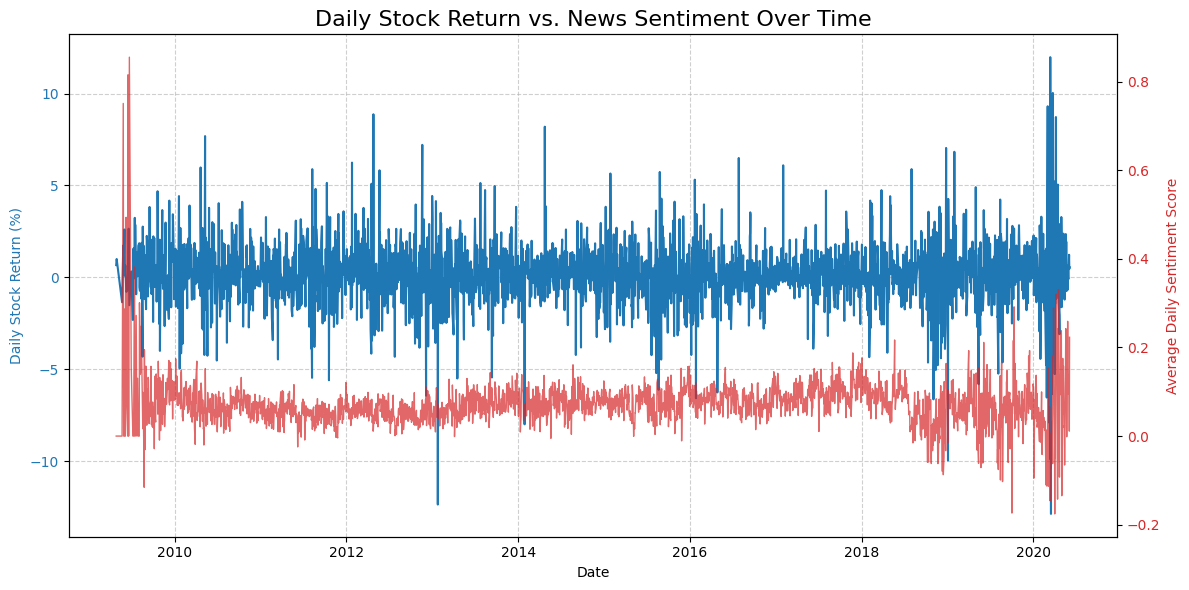

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Date' is datetime object for proper plotting
df_merged['Date'] = pd.to_datetime(df_merged['Date']) 

# Set up the figure and the first axis (for Daily Returns)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Daily Returns (Left Axis)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Stock Return (%)', color=color)
ax1.plot(df_merged['Date'], df_merged['Daily_Return'] * 100, color=color, linewidth=1.5, label='Daily Return')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

# Create a second axis (for Sentiment Score)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Average Daily Sentiment Score', color=color)  
ax2.plot(df_merged['Date'], df_merged['Avg_Daily_Sentiment'], color=color, linewidth=1.0, alpha=0.7, label='Avg. Sentiment Score')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and ensure date labels are readable
plt.title('Daily Stock Return vs. News Sentiment Over Time', fontsize=16)
fig.tight_layout() 
plt.show()

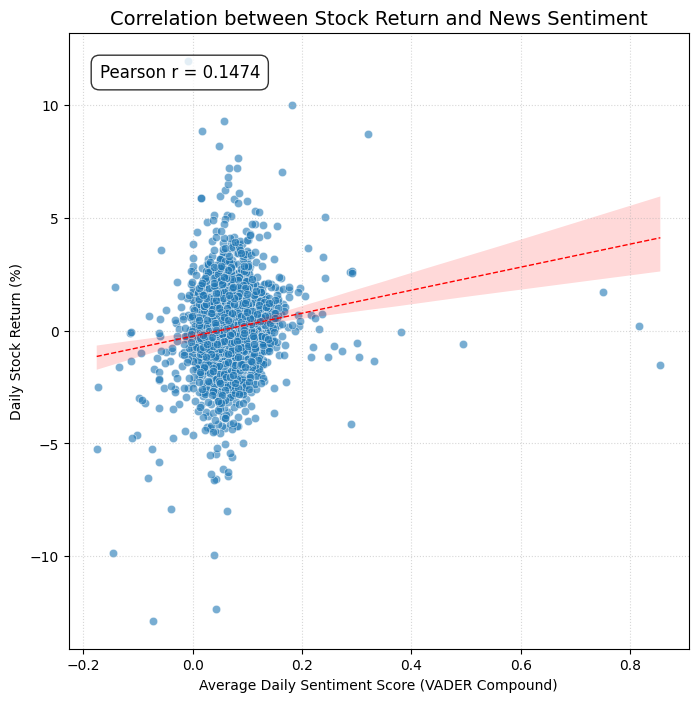

In [22]:
# Calculate the correlation coefficient (if you haven't already in Step 4)
correlation_r = df_merged['Daily_Return'].corr(df_merged['Avg_Daily_Sentiment'])

plt.figure(figsize=(8, 8))
sns.scatterplot(
    x=df_merged['Avg_Daily_Sentiment'], 
    y=df_merged['Daily_Return'] * 100, 
    alpha=0.6
)

# Add correlation line (regression line) for better visualization
sns.regplot(
    x=df_merged['Avg_Daily_Sentiment'], 
    y=df_merged['Daily_Return'] * 100, 
    scatter=False, 
    color='red', 
    line_kws={'linestyle': '--', 'linewidth': 1}
)

# Add title and correlation text
plt.title('Correlation between Stock Return and News Sentiment', fontsize=14)
plt.xlabel('Average Daily Sentiment Score (VADER Compound)')
plt.ylabel('Daily Stock Return (%)')

# Annotation for the correlation strength
plt.text(
    0.05, 0.95, 
    f"Pearson r = {correlation_r:.4f}", 
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8)
)

plt.grid(True, linestyle=':', alpha=0.5)
plt.show()